# Example: Regression with `QNNRegressor`

In this example we show how to train the `QNNRegressor` to solve a differential equation

## Imports

In [17]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt


from squlearn import Executor
from squlearn.encoding_circuit import ChebyshevPQC, ChebyshevTower, HEE_rzrxrz
from squlearn.observables import SummedPaulis
from squlearn.qnn import QNNRegressor, ODELoss, get_lr_decay
from squlearn.optimizers import Adam

We will use the Pennylane quantum framework for executing the circuits.

In [18]:
executor = Executor("pennylane", shots=None)

## `QNNRegressor` Setup

We start by defining a parameterized quantum circuit (PQC), that implements $\ket{f_{\bm{\theta}, \phi}(x)} = U_{\bm{\theta}} U_{\phi}(x) \ket{0}$.

  $U_{\phi}(x)$ encodes the ODE information and $U_{\bm{\theta}}$ manipulates the function space.

C:\Users\jsl-rf\AppData\Roaming\Python\Python310\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


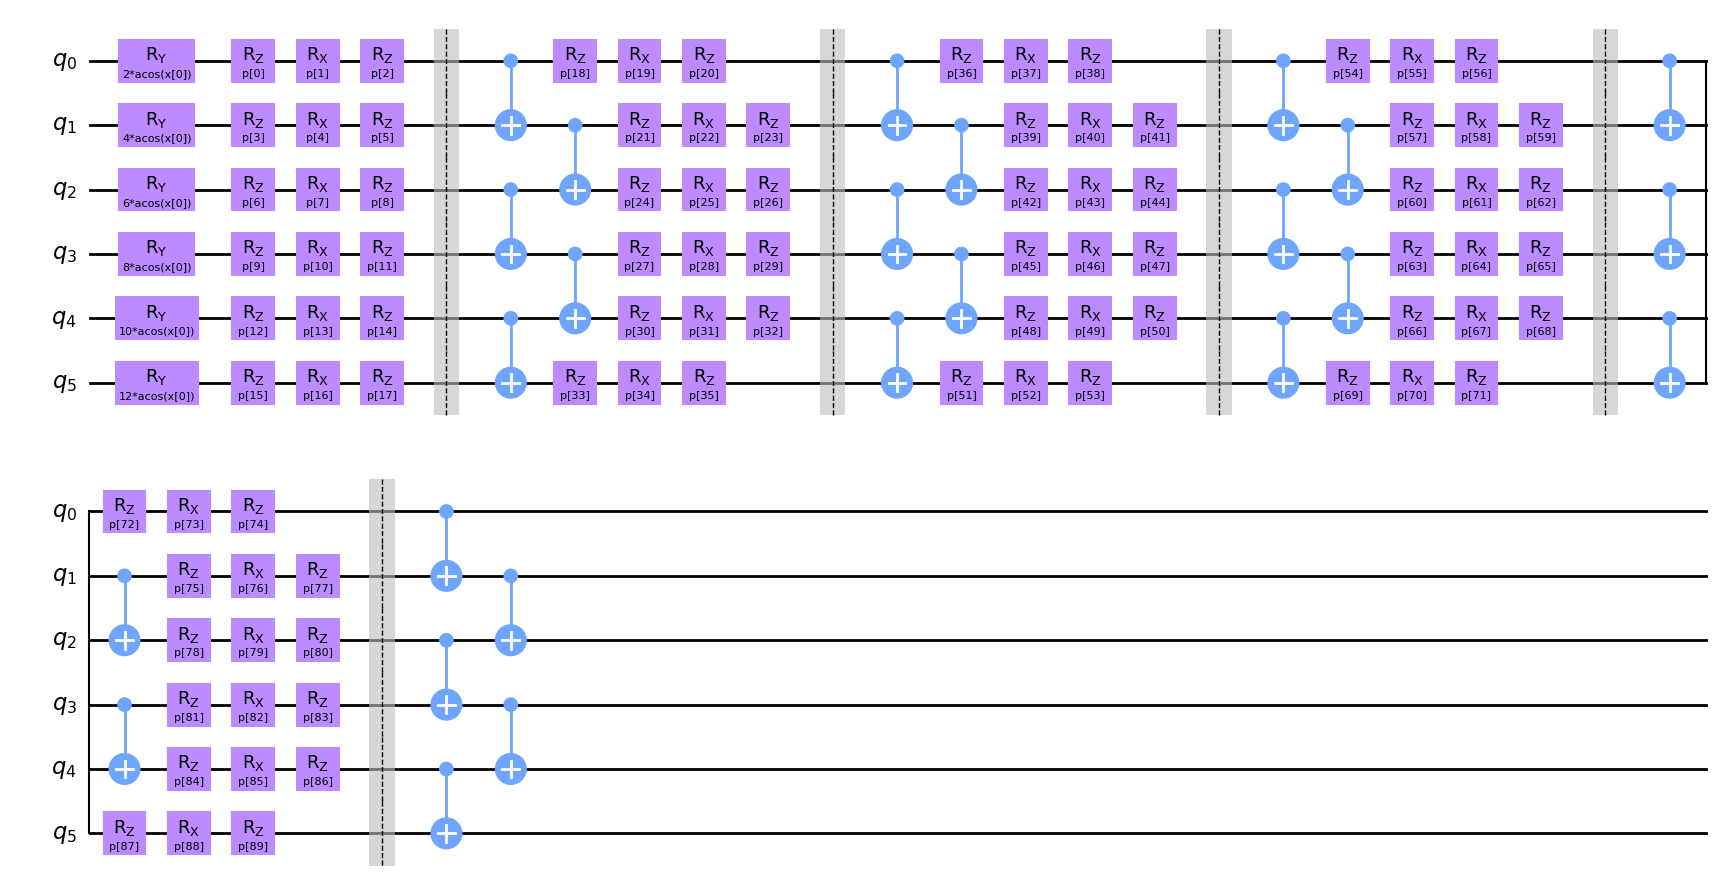

In [19]:
nqubits = 6
number_of_layers = 5


def ChebyshevTowerAndHEE(num_qubits, num_features, num_layers):
    circuit = ChebyshevTower(
        num_qubits=num_qubits,
        num_features=num_features,
        num_chebyshev=num_qubits,
        alpha=2,
        hadamard_start=False,
        rotation_gate="ry",
    )
    circuit += HEE_rzrxrz(num_qubits, num_features, num_layers)
    return circuit


# circuit = ChebyshevPQC(nqubits, 1, number_of_layers)
circuit = ChebyshevTowerAndHEE(nqubits, 1, number_of_layers)
circuit.draw("mpl")

We also need an observable

In [20]:
observable = SummedPaulis(nqubits, include_identity=False)
print(observable)

SparsePauliOp(['IIIIIZ', 'IIIIZI', 'IIIZII', 'IIZIII', 'IZIIII', 'ZIIIII'],
              coeffs=[ParameterExpression(1.0*p[0]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[2]), ParameterExpression(1.0*p[3]),
 ParameterExpression(1.0*p[4]), ParameterExpression(1.0*p[5])])



We create the `ODELoss` function with the homogeneous differential equation. There are two ways to do this:

1. Sympy symbolic expression
2. Callable function with gradient function

First, let us use sympy

In [5]:
x = sp.symbols("x")
f, dfdx, dfdxdx = sp.symbols("f dfdx dfdxdx")
k = 0.1
lamb = 20
eq = lamb * sp.exp(-lamb * x * k) * sp.sin(lamb * x) + lamb * k * f + dfdx
initial_vec = [1]

In [6]:
eq

dfdx + 2.0*f + 20*exp(-2.0*x)*sin(20*x)

Now we need to create the loss function object, the symbols involved in the ODE must be provided in the correct order: inpendent variable, function, and higher orders

In [7]:
loss_ODE_sp = ODELoss(
    eq, symbols_involved_in_ODE=[x, f, dfdx], initial_vec=initial_vec, boundary_handling="pinned"
)

Instead of providing a sympy symbolic equation with the symbols, we can also provide callable python function that implements the homogeneous differential equation and its gradient:

In [8]:
def eq_ODE(f_alpha_tensor):
    x, f, dfdx = f_alpha_tensor
    lamb = 20
    k = 0.1
    return lamb * np.exp(-lamb * x * k) * np.sin(lamb * x) + lamb * k * f + dfdx


def grad_ODE(f_alpha_tensor):
    lamb = 20
    k = 0.1
    x, f, dfdx = f_alpha_tensor

    return [lamb * k, 1]  # [deq_ODEdf, deq_ODEdfdx]


loss_ODE_np = ODELoss(
    eq_ODE, ODE_functional_gradient=grad_ODE, initial_vec=initial_vec, boundary_handling="pinned"
)

Now we can create the `QNNRegressor` with the PQC and cost operator. We also specify `loss_ODE` and `Adam` as the loss function and optimizer respectively. 

In [13]:
param_obs = observable.generate_initial_parameters(seed=1)
param_ini = circuit.generate_initial_parameters(seed=1)


adam = Adam(options={"maxiter": 125, "tol": 0.00009, "lr": get_lr_decay(0.05, 0.02, 125)})

ode_regressor = QNNRegressor(
    circuit,
    observable,
    executor,
    loss_ODE_np,  # or loss_ODE_sp
    adam,
    param_ini,
    param_obs,
    opt_param_op=True,
)

## Training

Now we are ready to train the model to solve the differential equation, (this takes time, around 120min)

In [14]:
x_space = np.linspace(0, 0.9, 15)
ref_values = np.zeros_like(x_space)
ode_regressor.fit(x_space, ref_values)

fit: 100%|██████████| 125/125 [1:47:30<00:00, 51.60s/it]


## Evaluation

Let's check the trained parameters of the PQC and operator

In [15]:
print("Result PQC params:", ode_regressor.param)
print("Result operator params:", ode_regressor.param_op)

Result PQC params: [-0.88282922  2.62091472 -6.56665303 -2.8657032  -4.59581246 -5.52416023
 -4.18011668 -1.8268274  -1.78474704  0.22840369 -1.29877023  1.85369231
 -3.79577126  5.35152598 -6.29826258  2.18486418 -0.98747273  0.52513008
 -4.80393601 -3.92722096  3.61949382  5.72359069 -1.98889858  2.47949686
  4.77653884  5.24538594 -4.78640885 -5.43424817 -3.81695244  4.82883924
 -4.73008447 -0.61807263  6.07485108 -0.0690098   2.23138287 -1.85718302
  2.18386589  4.18101669 -5.79865266  3.19076119  5.70691395  2.87682862
 -2.59280213  3.72016821 -5.07918418 -0.46738497  5.23359294 -3.08119254
 -2.27299348 -4.67248937 -6.47582509  2.07371374 -4.14706959 -2.72453094
  0.14882057 -5.22942204  0.7706981  -5.06412392  1.12658056  2.58730242
 -5.52803227 -1.37268448  3.20981654 -1.54280309 -5.35689343  0.43236308
  2.47855124 -0.03390754  5.99889085  0.96321405  4.8070676  -5.15604089
 -4.6936783   3.36931907 -1.28583041 -4.7130078   5.59265006 -1.91303089
  3.65148573  3.00989364  4.8167

Also let's plot the predicted function vs. the analytical solution

Text(0.5, 0, 'x')

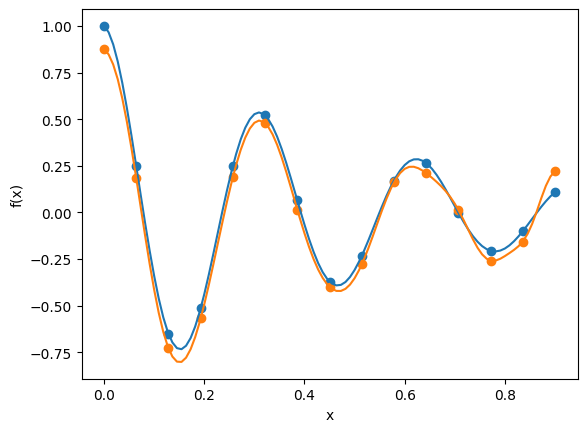

In [29]:
x = np.linspace(0, 0.9, 15)
y = ode_regressor.predict(x)
plt.scatter(x, np.cos(20 * x) * np.exp(-20 * 0.1 * x))
plt.scatter(x, y)

x_span = np.linspace(0, 0.9, 100)
y_span = ode_regressor.predict(x_span)

plt.plot(x_span, np.cos(20 * x_span) * np.exp(-20 * 0.1 * x_span))
plt.plot(x_span, y_span)

plt.ylabel("f(x)")
plt.xlabel("x")
